In [2]:
import pandas as pd
import os,sys,gc
!echo "deb http://downloads.skewed.de/apt/ bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool
sys.path.append('/content/drive/My Drive/phd/hSBM_Topicmodel/')
from sbmtm import sbmtm
import seaborn as sns
import graph_tool as gt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf

Executing: /tmp/apt-key-gpghome.dC10LtWkVt/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ P

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
directory="/content/drive/My Drive/phd/datasets/gtex/10"
os.chdir(directory)
model=sbmtm()
model.load_graph("graph.xml.gz")
data=gt.spectral.adjacency(model.g, model.g.edge_properties["count"]).toarray()
df = pd.DataFrame(data=data[1000:,:1000])

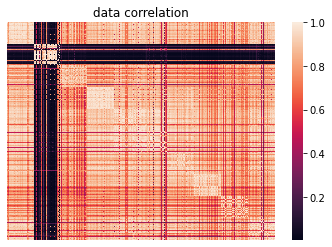

In [3]:
ax = sns.heatmap(pd.read_csv("mainTable.csv", index_col=0).corr(), annot=False, xticklabels=False, yticklabels=False)
ax.set_title("data correlation")
fig = ax.get_figure()
fig.savefig(f"gtex_pearson_tpm.png")
plt.show()

In [0]:
data_tensor = tf.convert_to_tensor(pd.read_csv("mainTable.csv", index_col=0).values)

In [0]:
def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def log2(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(2, dtype=numerator.dtype))
    return numerator / denominator

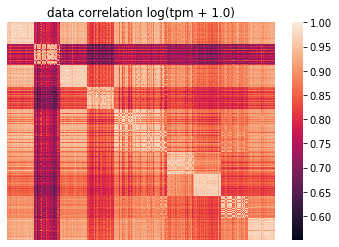

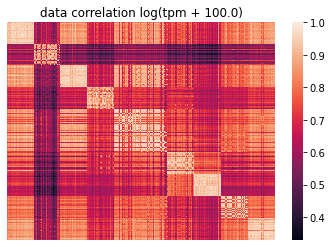

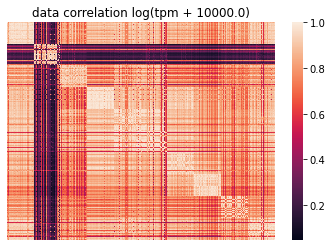

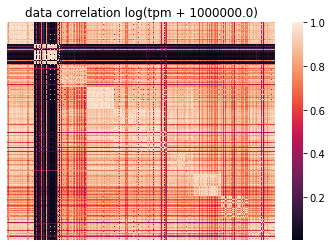

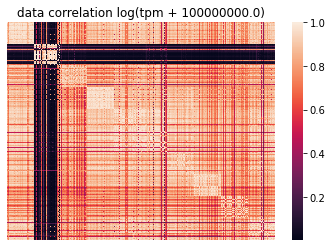

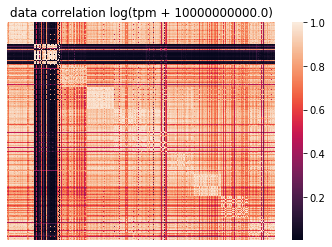

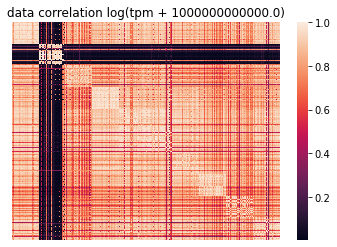

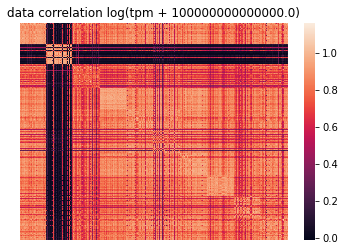

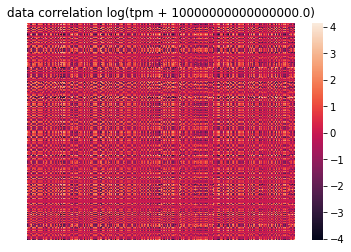

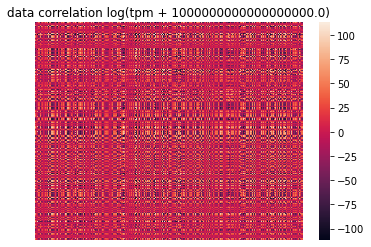

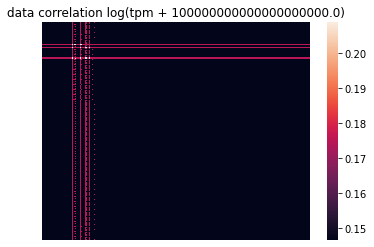

In [8]:
correlations = []
with tf.device("GPU"):
  for alpha in np.logspace(0,20,11):
    newdf= log2(data_tensor+tf.constant(alpha, dtype=data_tensor.dtype))
    corrMatrix = tfp.stats.correlation(newdf)
    avg_corr = tf.math.reduce_mean(corrMatrix, axis=None)
    correlations.append((alpha, avg_corr))
    ax = sns.heatmap(corrMatrix, annot=False, xticklabels=False, yticklabels=False)
    ax.set_title("data correlation log(tpm + %.1f)"%alpha)
    fig = ax.get_figure()
    fig.savefig(f"gtex_pearson_tpm_{alpha}.png")
    plt.show()

In [1]:
with tf.device("CPU"):
    corrMatrix = tfp.stats.correlation(data_tensor)
    avg_corr = tf.math.reduce_mean(corrMatrix, axis=None)
    fig, ax = plt.subplots(2,3, figsize=(20,12))
    ax=ax.ravel()
    sns.heatmap(corrMatrix, ax=ax[0], annot=False, xticklabels=False, yticklabels=False)
    ax[0].set_title("data correlation")

    sns.heatmap(tfp.stats.correlation(tf.math.round(data_tensor)), ax=ax[3], annot=False, xticklabels=False, yticklabels=False)
    ax[3].set_title("round(data) correlation")

    sns.heatmap(tfp.stats.correlation(log2(data_tensor+tf.constant(1, dtype=data_tensor.dtype))), ax=ax[1], annot=False, xticklabels=False, yticklabels=False)
    ax[1].set_title("log2(data+1) correlation")

    sns.heatmap(tfp.stats.correlation(tf.math.round(log2(data_tensor+tf.constant(1, dtype=data_tensor.dtype)))), ax=ax[4], annot=False, xticklabels=False, yticklabels=False)
    ax[4].set_title("round(log2(data+1)) correlation")

    sns.heatmap(tfp.stats.correlation(log10(data_tensor+tf.constant(1, dtype=data_tensor.dtype))), ax=ax[2], annot=False, xticklabels=False, yticklabels=False)
    ax[2].set_title("log10(data+1) correlation")

    sns.heatmap(tfp.stats.correlation(tf.math.round(log10(data_tensor+tf.constant(1, dtype=data_tensor.dtype)))), ax=ax[5], annot=False, xticklabels=False, yticklabels=False)
    ax[5].set_title("round(log10(data+1)) correlation")

    fig.savefig(f"gtex_pearson_data.png")
    plt.show()

NameError: ignored

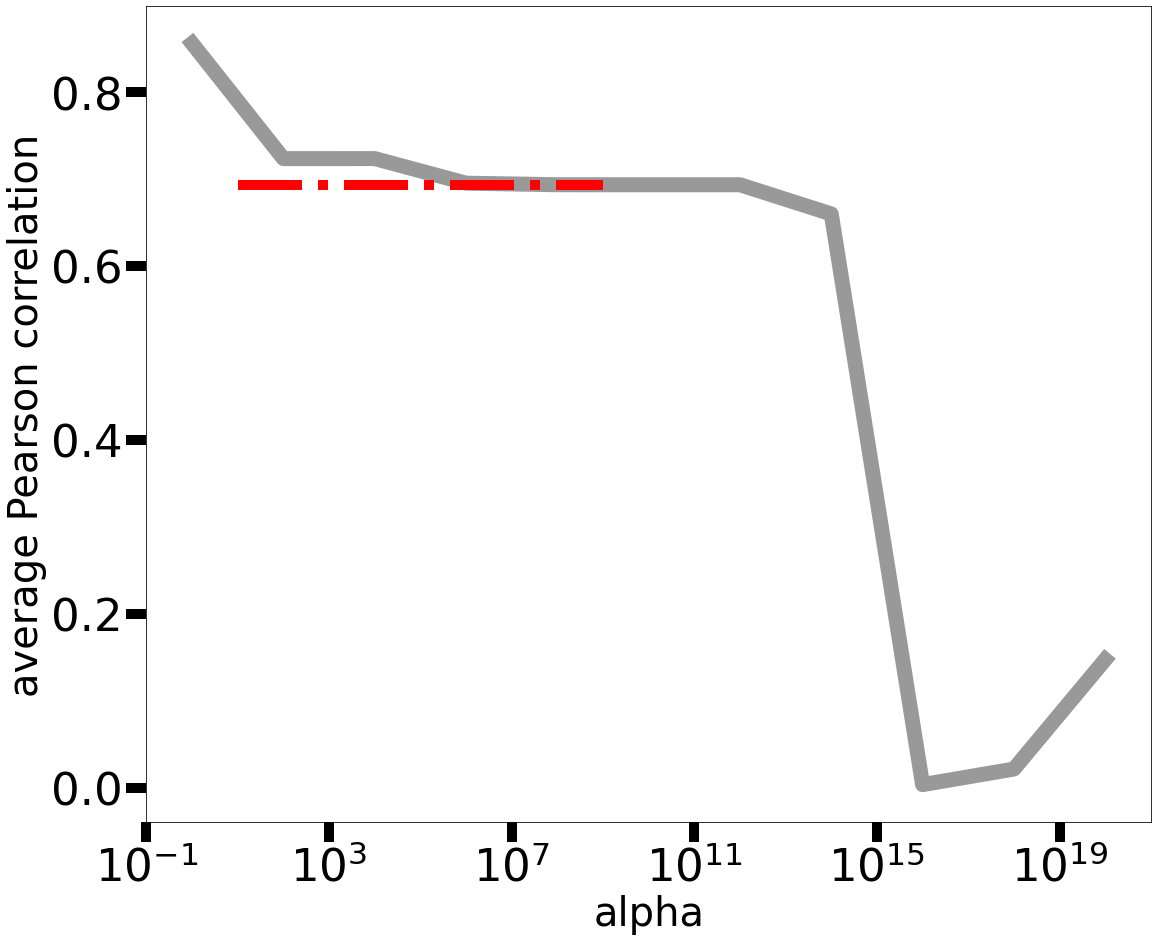

In [0]:
fig = plt.figure(figsize=(18,15))
plt.plot(np.array(correlations).T[0], np.array(correlations).T[1], lw=15, alpha=0.8, c="gray")
plt.plot(np.logspace(1,9),[avg_corr for _ in np.logspace(1,9)], lw=10, color="red", ls="-.")

plt.xlabel("alpha", fontsize=40)
plt.ylabel("average Pearson correlation", fontsize=40)
plt.tick_params(which="both",width=10, length=20, labelsize=45)


plt.xscale("log")
plt.show()

In [0]:
os.chdir("/content/drive/My Drive/phd/datasets/gtex")

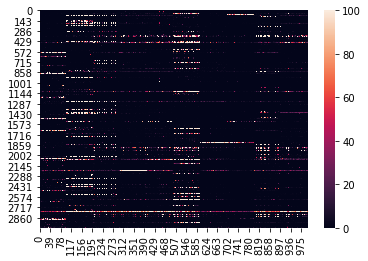

In [0]:
model = sbmtm()
model.load_graph("10/graph.xml.gz")
sns.heatmap(gt.spectral.adjacency(model.g, model.g.edge_properties["count"]).toarray()[1000:,:1000], vmax=100)

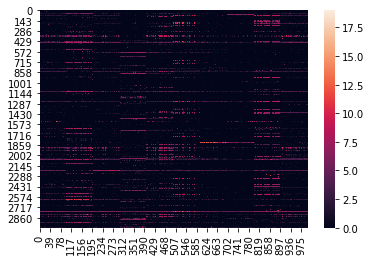

In [0]:
model = sbmtm()
model.load_graph("10/graph_log.xml.gz")
sns.heatmap(gt.spectral.adjacency(model.g, model.g.edge_properties["count"]).toarray()[1000:,:1000])

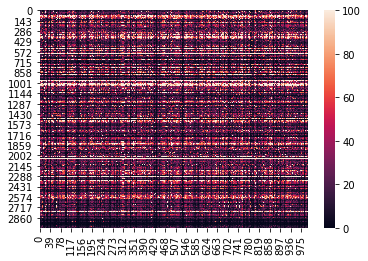

In [0]:
model = sbmtm()
model.load_graph("10/graph_hk.xml.gz")
sns.heatmap(gt.spectral.adjacency(model.g, model.g.edge_properties["count"]).toarray()[1000:,:1000], vmax=100)